# I. Introduction
> **Name** :  Dafa Wiratama
> **Batch** :  Data Science - Batch 9

>**Data Set Information**:
>The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

> The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

|  **Variable**   |                                 **Description**                                  |
|:---------------:|:--------------------------------------------------------------------------------:|
|       age       |                                                                                  |
|       job       |                                   type of job                                    |
|     marital     |                                  marital status                                  |
|    education    |                                                                                  |
|     default     |                              has credit in default?                              |
|     housing     |                                has housing loan?                                 |
|      loan       |                                has personal loan?                                |
|     contact     |                            contact communication type                            |
|      month      |                            last contact month of year                            |
|   day_of_week   |                           last contact day of the week                           |
|    duration     |                        last contact duration, in seconds                         |
|    campaign     |      number of contacts performed during this campaign and for this client       |
|      pdays      | days that passed by after the client was last contacted from a previous campaign |
|    previous     |      number of contacts performed before this campaign and for this client       |
|    poutcome     |                    outcome of the previous marketing campaign                    |
|  emp.var.rate   |                 employment variation rate - quarterly indicator                  |
| cons.price.idx  |                     consumer price index - monthly indicator                     |
|  cons.conf.idx  |                  consumer confidence index - monthly indicator                   |
|    euribor3m    |                      euribor 3 month rate - daily indicator                      |
|   nr.employed   |                    number of employees - quarterly indicator                     |

# II. Libraries Import

In [298]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

> Random Seed Initialization

In [299]:
warnings.filterwarnings('ignore')
np.random.seed(13)

# III. Data Loading
> after everything was imported, we can load the data into pandas dataframe

In [300]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';')

In [301]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


- Mean Age is aproximately 41 years old. Minimum: 18 years old and Maximum: 95 years old.

- The mean balance is 1,528. However, the Standard Deviation (std) is a high number so we can understand through this that the balance is heavily distributed across the dataset.

- As the data information said it will be better to drop the duration column since duration is highly correlated in whether a potential client will buy a term deposit. Also, duration is obtained after the call is made to the potential client so if the target client has never received calls this feature is not that useful. The reason why duration is highly correlated with opening a term deposit is because the more the bank talks to a target client the higher the probability the target client will open a term deposit since a higher duration means a higher interest (commitment) from the potential client.

There are not that much insights we can gain from the descriptive dataset since most of our descriptive data is located not in the "numeric" columns but in the "categorical columns".

In [302]:
df = dataset.drop('duration', axis=1).copy()

> after dropping the `duration` feature, we can check the dataset information again.

In [303]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


> let's rename the dataframe columns to make it easier to use.

In [304]:
df.columns = [name.replace('.', '_') for name in df.columns]
df['target'] = df.pop('y').replace({'yes': 1, 'no': 0})

> as we can see from the frequency that we have an imbalance in the target variable, so we will need a special treatment for this.

In [305]:
df.target.value_counts()

0    36548
1     4640
Name: target, dtype: int64

> from the frame information we can see that the dataset has no missing values (NaN).

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp_var_rate    41188 non-null  float64
 15  cons_price_idx  41188 non-null  float64
 16  cons_conf_idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

> from the `Measure of Central Tendency` we can see that the dataset has many outliers.

In [307]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp_var_rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons_price_idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons_conf_idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr_employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100
target,41188.0,0.112654,0.316173,0.000,0.000,0.000,0.000,1.000


> from the category feature there are many category named `unknown` **does it mean that they are missing values?**
> I dont think so because the `unknown` category is not a missing value. and it is a category defined by the dataset itself.

In [308]:
for col in df.select_dtypes(include=['object']).columns:
    print(col, df[col].unique())

job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital ['married' 'single' 'divorced' 'unknown']
education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default ['no' 'unknown' 'yes']
housing ['no' 'yes' 'unknown']
loan ['no' 'yes' 'unknown']
contact ['telephone' 'cellular']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome ['nonexistent' 'failure' 'success']


# IV. Exploratory Data Analysis
> After we inspected the dataframe lets start the exploratory data analysis. in this section we will try to uncover the data structure and the relationships between the features. then we will try to find the best features to use in the model.

In [309]:
features_mapping = {}

> Some Utility Functions to help me to visualize the features.

In [310]:
def split_target(df, column, target):
    return df[df[target] == 0][[column]], df[df[target] == 1][[column]]


def calculate_kde(value):
    _space = np.linspace(value.min(), value.max(), 100)
    kde = stats.gaussian_kde(value)
    return _space, kde(_space)


def join_space(space_a, space_b):
    return np.linspace(min(space_a.min(), space_b.min()), max(space_a.max(), space_b.max()), 100)


def plot_kde(space, *kde, labels: list, ax=plt):
    for i, p in enumerate(kde):
        ax.plot(space, p)
    ax.legend(labels)


def plot_class_dist(df, column, transformer=None, target='target'):
    _df = df[[column, target]].copy().dropna()

    neg, pos = split_target(_df, column, target)
    _neg_space, _neg_kde = calculate_kde(neg[column])
    _pos_space, _pos_kde = calculate_kde(pos[column])
    _space = join_space(_neg_space, _pos_space)

    fig, ax = plt.subplots(1, 4 if transformer else 2, figsize=(8 * 4, 6))
    fig.suptitle(f'"{column.title()}" Distribution')

    plot_kde(_neg_space, _neg_kde, _pos_kde, _neg_kde + _pos_kde, labels=['Negative', 'Positive', 'Feature'], ax=ax[0])
    ax[0].set_title('Probability')
    ax[0].set_xlabel(f'{column.title()}')
    ax[1].boxplot([neg[column], pos[column]])
    ax[1].set_title('Distribution')
    ax[1].set_xlabel(f'{column.title()}')

    if transformer:
        _df[column] = transformer.fit_transform(_df[[column]])

        neg, pos = split_target(_df, column, target)
        _neg_space, _neg_kde = calculate_kde(neg[column])
        _pos_space, _pos_kde = calculate_kde(pos[column])
        _space = join_space(_neg_space, _pos_space)

        plot_kde(_neg_space, _neg_kde, _pos_kde, _neg_kde + _pos_kde, labels=['Negative', 'Positive', 'Feature'],
                 ax=ax[2])
        ax[2].set_title('Transformed Probability')
        ax[3].boxplot([neg[column], pos[column]])
        ax[2].set_xlabel(f'{column.title()}')
        ax[3].set_title('Transformed Distribution')
        ax[3].set_xlabel(f'{column.title()}')

    plt.show()

> Ok lets start by plotting the correlation matrix between the features. and from there we can see that not many features are correlated with each other. and most of them are not correlated with the target variable. but this is not final correlation because we still yet to finding the ordinality of categorical features.

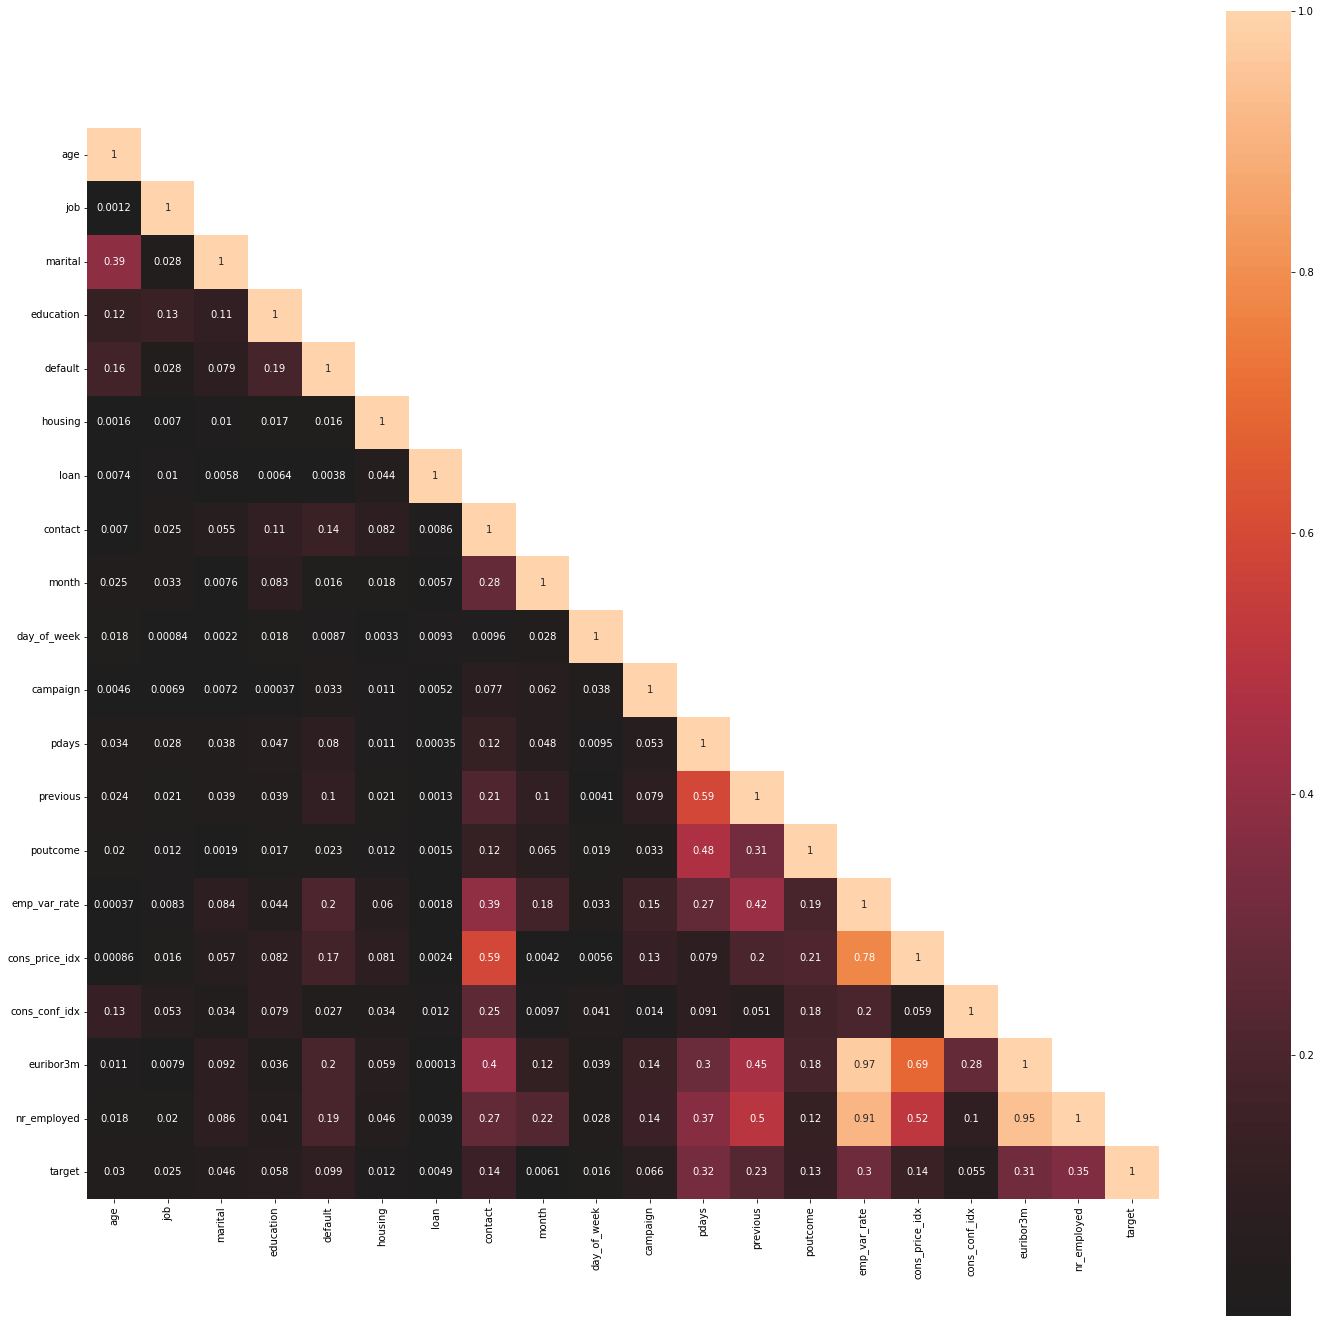

In [311]:
_df = df.copy()
_categorical_feature = _df.select_dtypes(exclude=['number']).columns.to_list()

for column in _categorical_feature:
    _df[column] = _df[column].astype('category').cat.codes

_corr = _df.corr().abs()

plt.figure(figsize=(8 * 3, 8 * 3))
sns.heatmap(_corr.dropna(), annot=True, center=0, mask=np.triu(_corr, k=1), square=True);

In [312]:
def calculate_correlation(df, target='target'):
    leaderboard = df.corr(method='spearman').abs()[target]
    leaderboard += df.corr(method='kendall').abs()[target]
    leaderboard += df.corr(method='pearson').abs()[target]
    leaderboard /= 3
    return leaderboard.sort_values(ascending=False).drop(target)

> to make thing more clear we need to plot correlation between the features and the target variable and sort them in descending order. and set our threshold to `max correlation / 5` as lower bound. as we can see that many categorical features are highly correlated with the target variable. even-though they are not sorted by ordinality so we hope we can improve the correlation by finding their ordinality.

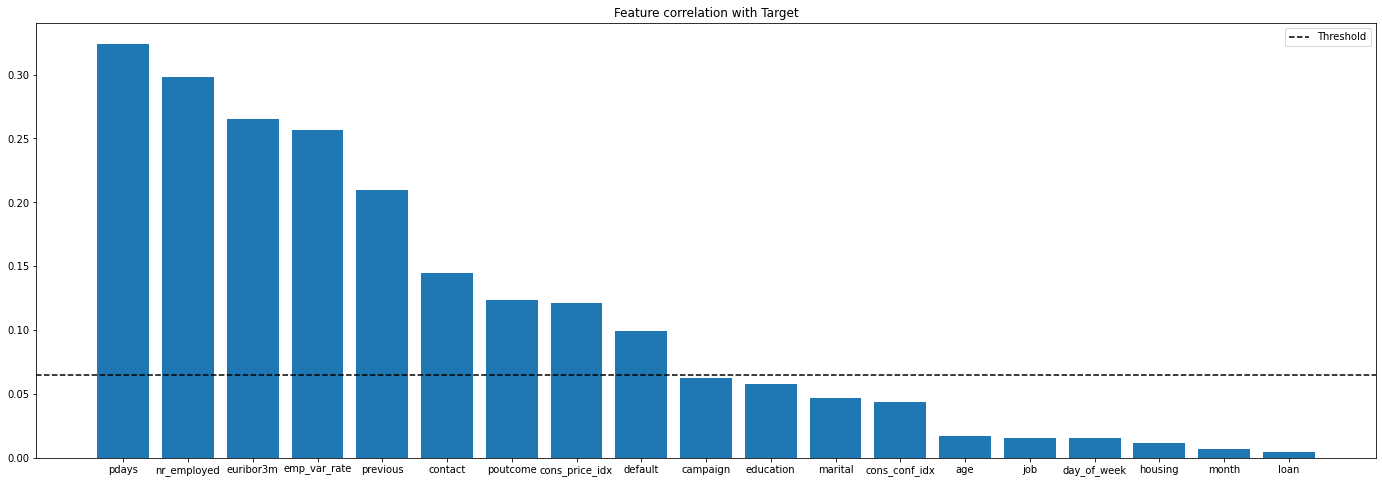

In [313]:
plt.figure(figsize=(8 * 3, 8))
plt.title('Feature correlation with Target')

leaderboard = calculate_correlation(_df)
plt.bar(leaderboard.index, leaderboard.values, align='center')

correlation_threshold = leaderboard.max() / 5.
leaderboard = leaderboard[leaderboard > correlation_threshold].index.tolist()

plt.axhline(y=correlation_threshold, color='k', linestyle='--', label='Threshold')
plt.legend();

> at this section there was some information that we can conclude from the plot. the number of `pdays` have hight correlation with the target because in my perpective if the customer was contacted previously the there is more likely no deposit. and if the customer is new then there is more likely a deposit.

> # Numerical Features
> for numerical feature i will use `maximum_normalize_residual_test` to test whether the feature is containing outlier or not. since we have a lot of outliers from the `Measure of central tendency` and we will find a way to handle them.

In [314]:
def maximum_normalize_residual_test(sample, alpha=0.05, verbose=False):
    n_sample = len(sample)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample)

    g_calculated = np.max(np.abs(sample - sample_mean)) / sample_std

    t_value = stats.t.ppf(1 - (alpha / (2 * n_sample)), n_sample - 2)
    g_crit = ((n_sample - 1) * np.sqrt(np.square(t_value)))
    g_crit /= (np.sqrt(n_sample) * np.sqrt(n_sample - 2 + np.square(t_value)))

    if verbose:
        print(f'Grubbs Statistic: {g_calculated:.3f}')
        print(f'Critical Value: {g_crit:.3f}')
        if g_crit > g_calculated:
            print("Accept Null Hypothesis, H0 : Sample doesn't contain outliers")
        else:
            print("Reject Null Hypothesis, H1 : Sample contains outliers")

    return g_calculated > g_crit

> using this function we can iterate over all the numerical features and check if they are containing outliers or not.

In [315]:
def outlier_finder(df, columns):
    normal_columns = []
    outlier_columns = []

    for col in columns:
        is_contain_outlier = maximum_normalize_residual_test(df[col])
        if is_contain_outlier:
            outlier_columns.append(col)
        else:
            normal_columns.append(col)

    return normal_columns, outlier_columns

> and this function will be used to find the solution for the outliers either using Power Transformation or Box Cox Transformation.

In [316]:
def outlier_handler(
        df,
        columns,
        handlers: tuple = (PowerTransformer(method='box-cox'), PowerTransformer(method='yeo-johnson'))
):
    success_columns = {}
    failed_columns = []
    for column in columns:
        is_success = False

        for handler in handlers:
            try:
                sample = handler.fit_transform(df[[column]])
                is_contain_outlier = maximum_normalize_residual_test(sample)

                if not is_contain_outlier:
                    success_columns[column] = handler

                    is_success = True
                    break
            except Exception as e:
                pass

        if not is_success:
            failed_columns.append(column)

    return success_columns, failed_columns

> let's check the result of our outlier detection. we will try to detect if the `age` column is containing outliers or not.

In [317]:
maximum_normalize_residual_test(df['age'], verbose=True);

Grubbs Statistic: 5.563
Critical Value: 4.853
Reject Null Hypothesis, H1 : Sample contains outliers


>> ### Outlier Detection
>> after everything set up we can start the outlier detection through every numerical feature.
>> and yep we can see that many column have outliers. so we will try to find the solution for the outliers in the next step.

In [318]:
features = df.select_dtypes('number').columns.tolist()
features.remove('target')

normal_columns, outlier_columns = outlier_finder(df, features)
features_mapping.update({column: StandardScaler() for column in normal_columns})

print(f'Normal Columns: {normal_columns}')
print(f'Outlier Columns: {outlier_columns}')

Normal Columns: ['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
Outlier Columns: ['age', 'campaign', 'pdays', 'previous']


>> ### Outlier Handling
>> now we will try to find the solution for the outliers in the `outlier_columns`
>> as we can see from the result majority of the outliers are handled successfully using Power Transformation.
>> but we still have some outliers that we can't handle. so at the end we need to take care the column manualy

In [319]:
handled, unhandled = outlier_handler(df, outlier_columns)
features_mapping.update(handled)

print(f'Handled Columns: {handled}')
print(f'Unhandled Columns: {unhandled}')

Handled Columns: {'age': PowerTransformer(method='box-cox'), 'campaign': PowerTransformer(method='box-cox'), 'previous': PowerTransformer()}
Unhandled Columns: ['pdays']


> ### Feature Distribution

>> ### No-Outlier Features
>> just for good measure we will check if our outlier detection is working properly or not. by inspecting the distribution of the features.
>
>> **Wait how to read those graphs?**
>> from left to right
>> 1st one is the histogram of the feature in dense form.
>> 2nd one is the box plot of the feature.
>> 3rd one is the density plot of the feature after the normalization.
>> 4th one is the boxplot plot of the feature after the transformation.
>
>> since this group is for normal column we will only see scaling effect of StandardScaler. that change the distribution of the feature but not changing relative distribution.

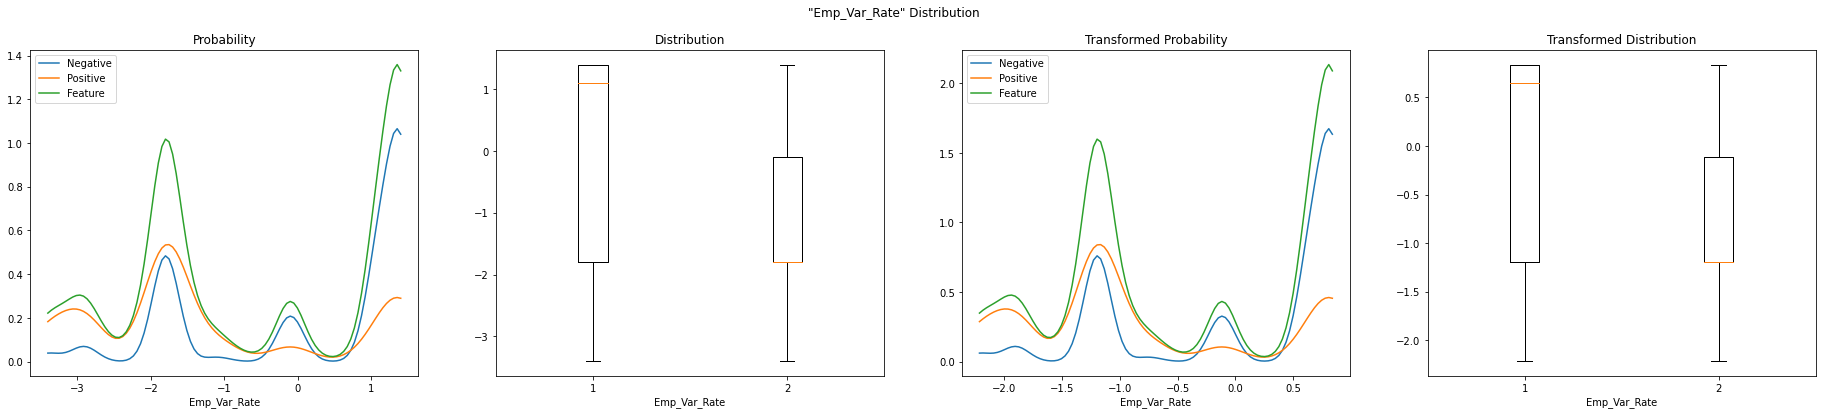

In [320]:
plot_class_dist(df, 'emp_var_rate', transformer=features_mapping['emp_var_rate'])

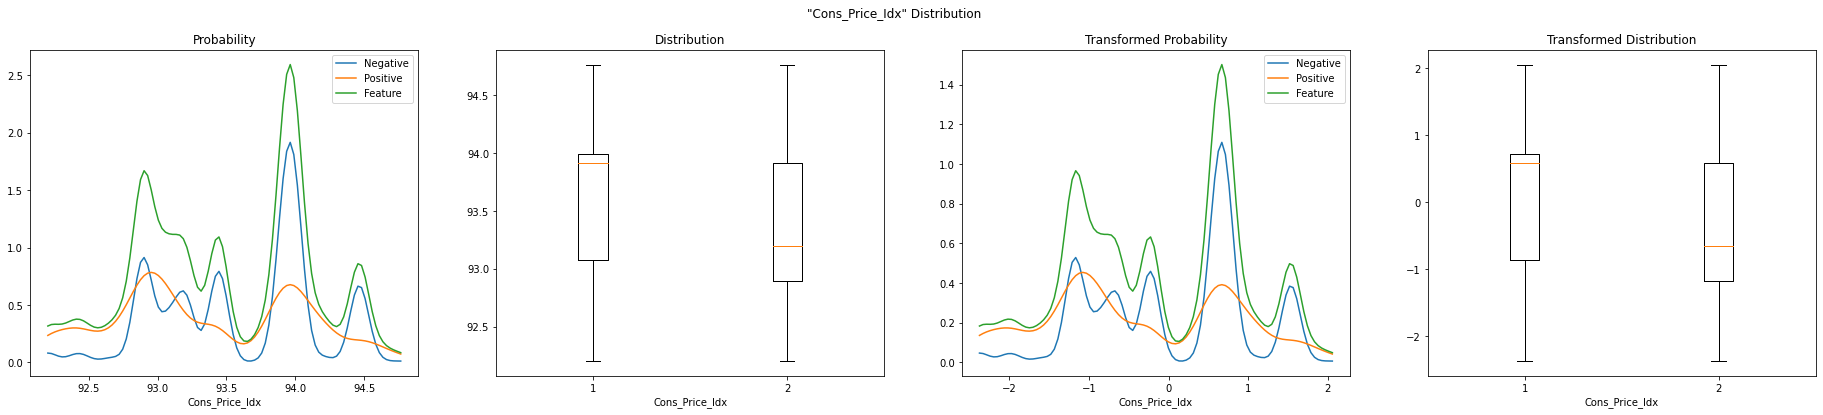

In [321]:
plot_class_dist(df, 'cons_price_idx', transformer=features_mapping['cons_price_idx'])

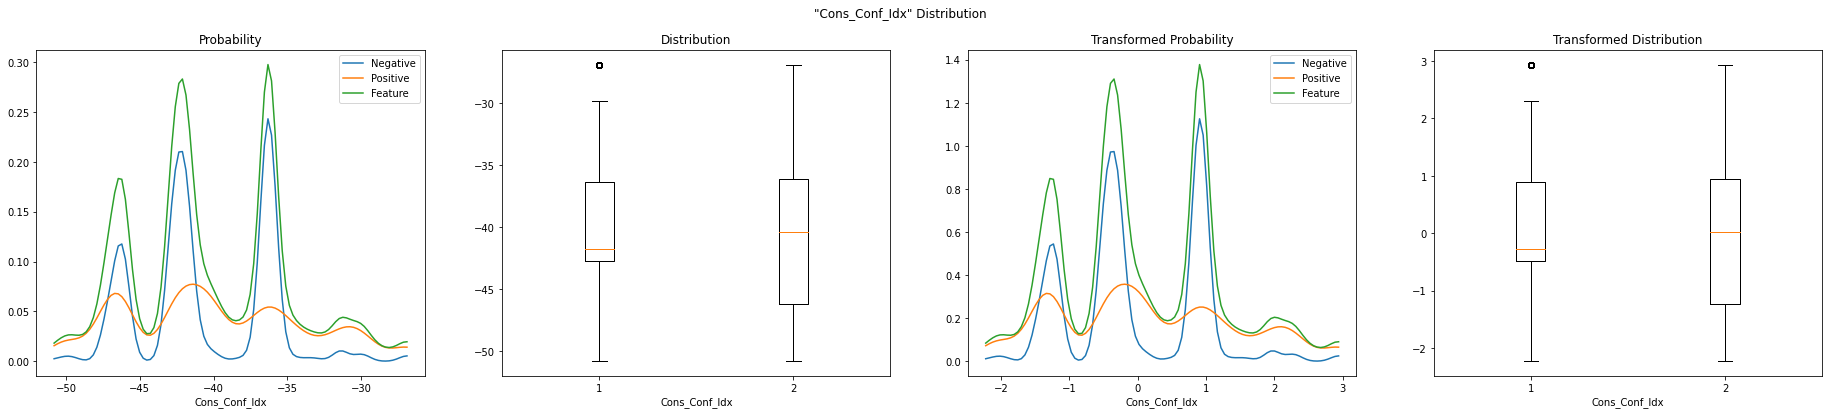

In [322]:
plot_class_dist(df, 'cons_conf_idx', transformer=features_mapping['cons_conf_idx'])

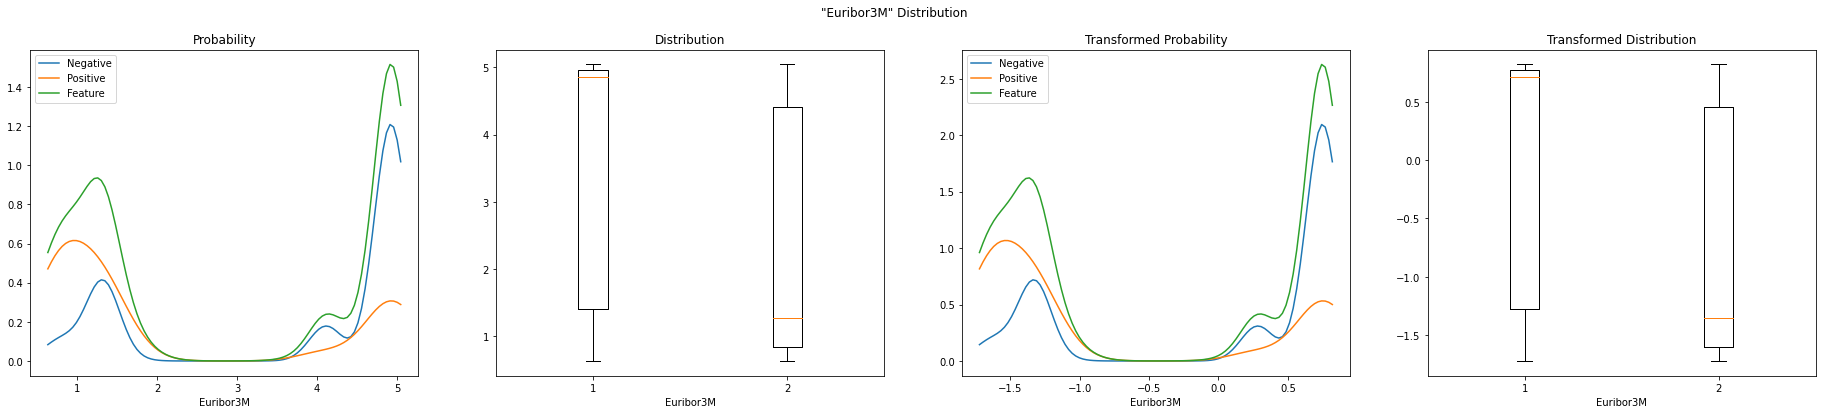

In [323]:
plot_class_dist(df, 'euribor3m', transformer=features_mapping['euribor3m'])

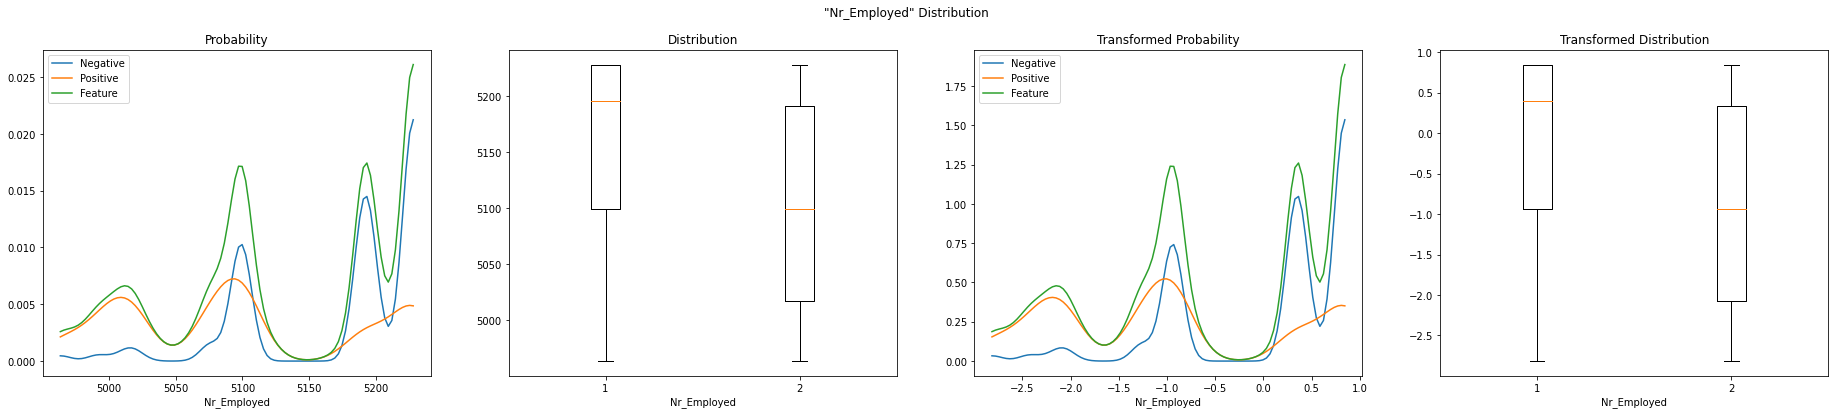

In [324]:
plot_class_dist(df, 'nr_employed', transformer=features_mapping['nr_employed'])

>>> #### Conclusion
>>> after seeing all the graphs from no-outlier features we can see that most of them have no resemblance to the normal distribution.
>>
>>> **so what we do then?**
>>> it is not uncommon to see that in this kind of dataset because so many feature effecting the target variable if we want we can try to filter those features to find the original distribution.

>> ### Outlier Features

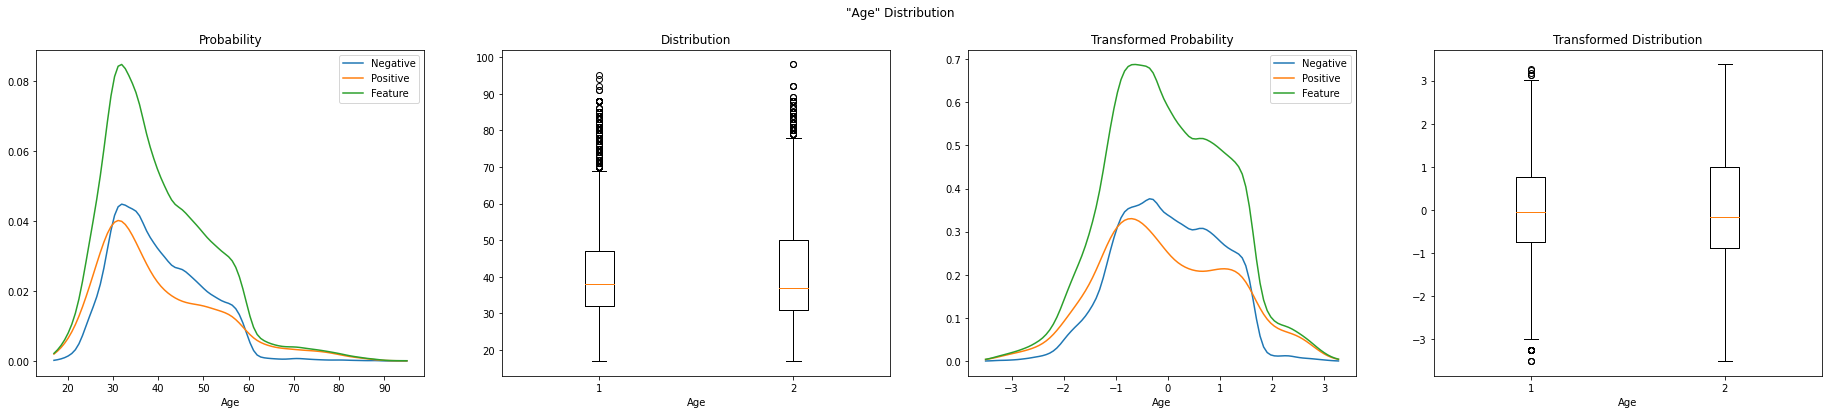

In [325]:
plot_class_dist(df, 'age', transformer=features_mapping['age'])

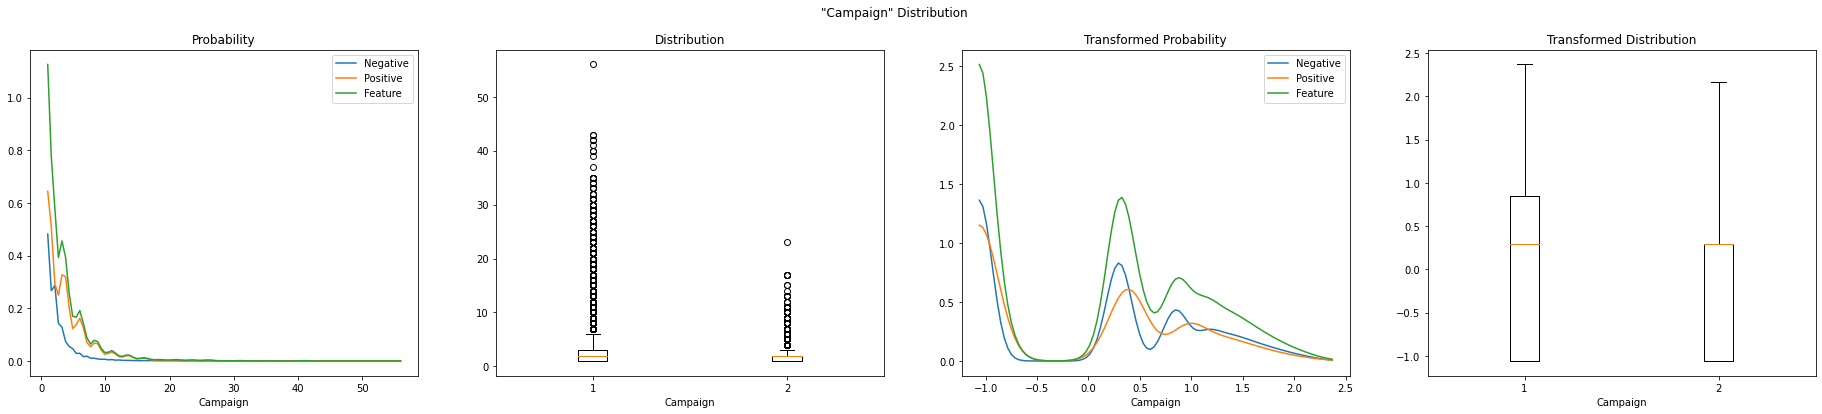

In [326]:
plot_class_dist(df, 'campaign', transformer=features_mapping['campaign'])

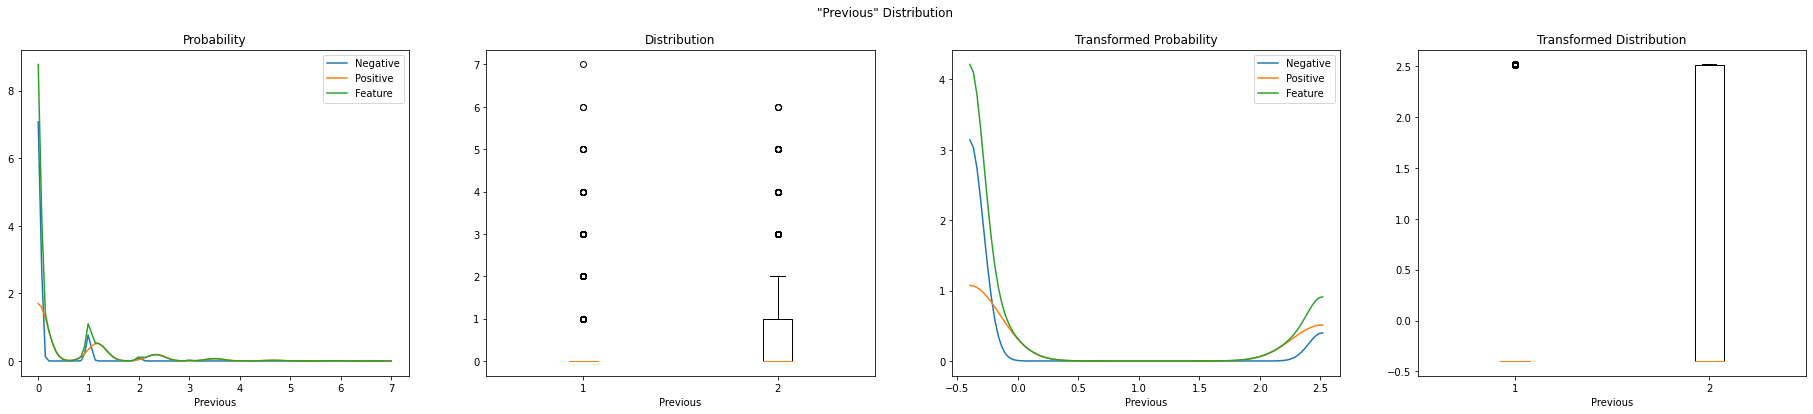

In [327]:
plot_class_dist(df, 'previous', transformer=features_mapping['previous'])

>>> #### Conclusion
>>> in this group is the feature that has an outlier in their distribution. but we already have the solution to their respective outliers. and from the visualisation we can see that almost all outlier are in the 3x range after transformation. so we can conclude that we successfully handled the outliers.

>> ### Unhandled Outlier Features
>> this time we need to handle the outliers manually. because the Out-Of-The-Box method didn't work for some reason. so lets check the distribution of the unhandled outliers.

In [328]:
pdays_normalizer = Pipeline([
    ('normalizer', FunctionTransformer(lambda x: (x + 1).replace(1000, 0))),
    ('scaler', StandardScaler())
])
pdays_normalizer.fit(df[['pdays']])
features_mapping.update({'pdays': pdays_normalizer})

maximum_normalize_residual_test(pdays_normalizer.transform(df[['pdays']]), verbose=True);

Grubbs Statistic: 18.368
Critical Value: 4.853
Reject Null Hypothesis, H1 : Sample contains outliers


>> from the visualisation we can see that most of the outlier sit at the end of distribution.
>
>> **why that happened**
>> this is because the feature have a rule if the customer not contacted yet then the value is 999 that is why the outlier sit at the end of the distribution
>> and because of that i will just re-insert the value 999 to the start of the distribution. and shift the other values to the right by one
>
>> and from the transformation we can eliminate the outliers. even though the feature is not normal distribution.

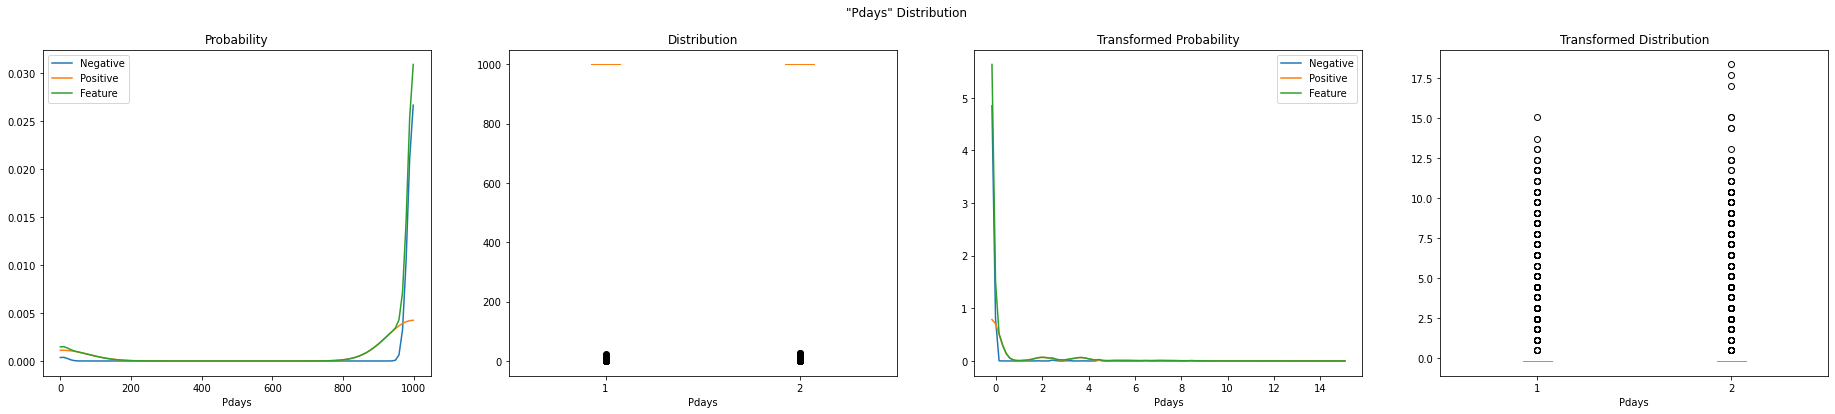

In [329]:
plot_class_dist(df, 'pdays', pdays_normalizer)

> ## Categorical Features
> after every numerical feature is normalized and handled we can move to categorical features.
> because the categorical features need its ordinal value to be able to calculate the correlation, so we will need to find the ordinal value of each category first.
>
> **How?**
> this time i will sort them by their percentage of the target variable in their respective category so at least we get some degree of correlation.

In [330]:
target = 'target'

ordinals = {}

for column in df.select_dtypes(exclude=['number']).columns:
    _df = df.copy()
    _df[column] = df[column].astype('category').cat.codes
    corr = _df.corrwith(_df[target]).abs()[column]
    ordinal = df[[column, target]].groupby(column).mean().sort_values(by=target, ascending=True).index.values
    ordinals[column] = OrdinalEncoder(categories=[ordinal])

features_mapping.update(ordinals)

> let see the ordered categorical features.

In [331]:
for col in ordinals:
    print(f'{col}: {ordinals[col].categories[0]}')

job: ['blue-collar' 'services' 'entrepreneur' 'housemaid' 'self-employed'
 'technician' 'unknown' 'management' 'admin.' 'unemployed' 'retired'
 'student']
marital: ['married' 'divorced' 'single' 'unknown']
education: ['basic.9y' 'basic.6y' 'basic.4y' 'high.school' 'professional.course'
 'university.degree' 'unknown' 'illiterate']
default: ['yes' 'unknown' 'no']
housing: ['unknown' 'no' 'yes']
loan: ['unknown' 'yes' 'no']
contact: ['telephone' 'cellular']
month: ['may' 'jul' 'nov' 'jun' 'aug' 'apr' 'oct' 'sep' 'dec' 'mar']
day_of_week: ['mon' 'fri' 'wed' 'tue' 'thu']
poutcome: ['nonexistent' 'failure' 'success']


# V. Data Preprocessing

> ## Feature Selection
> let's pick our best correlated features to train our model.

In [332]:
_df = df.copy()

for col in _df.columns:
    if col is not 'target':
        _df[col] = features_mapping[col].fit_transform(_df[[col]])

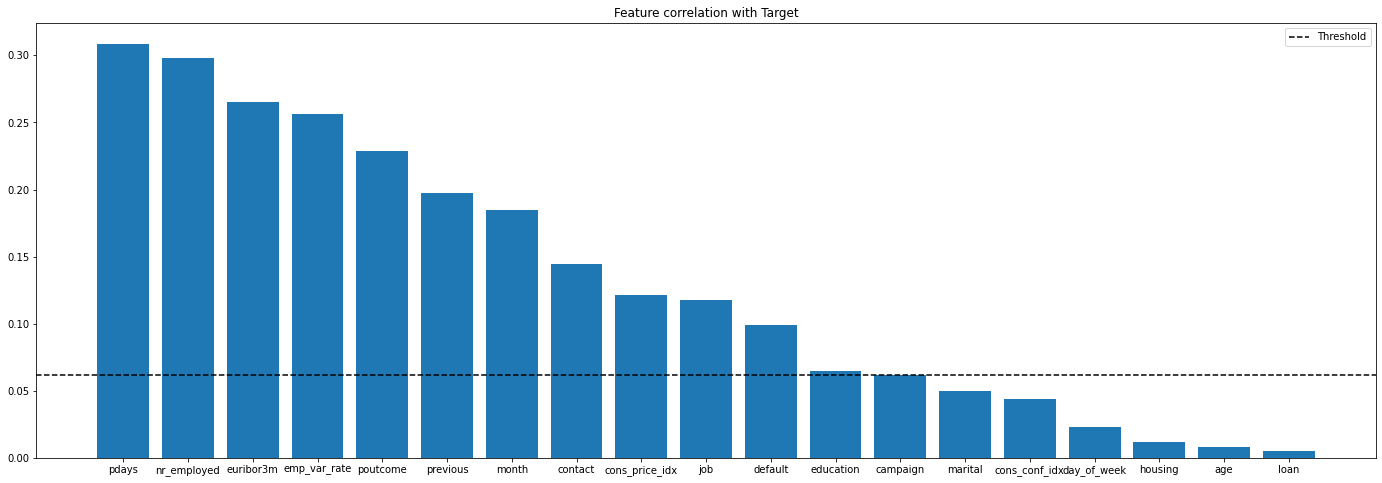

In [333]:
plt.figure(figsize=(8 * 3, 8))
plt.title('Feature correlation with Target')

leaderboard = calculate_correlation(_df)
plt.bar(leaderboard.index, leaderboard.values, align='center')

correlation_threshold = leaderboard.max() / 5.
leaderboard = leaderboard[leaderboard > correlation_threshold].index.tolist()

plt.axhline(y=correlation_threshold, color='k', linestyle='--', label='Threshold')
plt.legend();

> After we rescored the correlation we can see that the features that have the highest correlation with the target variable are above our minimum threshold. so at this case we will not use campaign, marital, cons_conf_id, day_of_week, housing, age and loan

> ## Cross Validation Split
> to train and validate our model we will use a cross validation split this case we split it into 3 parts. 1 for training and 2 for validation and the last one for testing.

In [334]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, random_state=13, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13, stratify=y_train)

> let's check the shape of our data.

In [335]:
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print()
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print()
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (32620, 19)
y_train: (32620,)

x_val: (8156, 19)
y_val: (8156,)

x_test: (412, 19)
y_test: (412,)


> ## Class Balancing
> since our dataset came with imbalance problem we need to balance it. first i will do upsampling the majority class and then downsampling the minority class.

In [336]:
y_train.value_counts()

0    28945
1     3675
Name: target, dtype: int64

In [337]:
sample_pos = x_train[y_train == 1]
sample_neg = x_train[y_train == 0]

n_neg = len(sample_neg)

pos = pd.concat([sample_pos, sample_pos])
neg = sample_neg.sample(n_neg // 2)

x_train = pd.concat([pos, neg])
y_train = np.array([1] * len(pos) + [0] * len(neg))

idx = np.random.permutation(len(x_train))
x_train = x_train.iloc[idx]
y_train = y_train[idx]

print(f'Negative: {len(x_train[y_train == 0])}')
print(f'Positive: {len(x_train[y_train == 1])}')

Negative: 14472
Positive: 7350


> ## Class Weights
> since we have done upsampling and downsampling but the dataset still have imbalance problem we need to balance the class weights. by calculating the class weights at least we try to prevent the model to bias toward the majority class.

> after the calculation we can see that the positive class carry more weight than the negative class.

In [338]:
n_pos = len(x_train[y_train == 1])
n_neg = len(x_train[y_train == 0])
n_total = n_pos + n_neg

class_weight = {0: (1 / n_neg) * (n_total / 2), 1: (1 / n_pos) * (n_total / 2)}

class_weight

{0: 0.75393864013267, 1: 1.4844897959183674}

> ## Preprocessing Pipeline
> after everything is done we will create our preprocessing pipeline. so we will use the same steps we used before for whatever data we will use.
> and fitting our preprocessing pipeline with our training data only.

In [339]:
features = [(col, features_mapping[col], [col]) for col in leaderboard]

preprocessing_pipeline = ColumnTransformer(features)
preprocessing_pipeline.fit(x_train);

In [340]:
train_ds, val_ds, test_ds = (x_train, y_train), (x_val, y_val), (x_test, y_test)

# VI. Model Definition
> in this step we will define our model.
> i use a function to help me set up the model pipeline. and find the best hyper-parameters.

> ## Model Pipeline
> this function will wrap our model with preprocessing pipeline.

In [341]:
create_model_pipeline = lambda model: Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', model),
])

> ## Model Hyper-parameters
> we will use a grid search to find the best hyper-parameters for our model.

> ## Logistic Regression
> Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. The most common logistic regression models a binary outcome; something that can take two values such as true/false, yes/no, and so on.

> we will use our precalculated class weights to balance the class and we suppy the grid params to try different hyper-parameters.

> **Params**
> max_iter: maximum number of iterations to perform.

In [342]:
lr_model = create_model_pipeline(LogisticRegression(max_iter=1000, class_weight=class_weight))

> ## Support Vector Machine
> Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. The most common logistic regression models a binary outcome; something that can take two values such as true/false, yes/no, and so on.

> **Params**
> all default params.

In [343]:
svm_model = create_model_pipeline(LinearSVC(class_weight=class_weight))

> ## Decision Tree
> Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

> **Params**
> max_depth: maximum depth of the tree.

In [344]:
dt_model = create_model_pipeline(DecisionTreeClassifier(max_depth=15))

> ## Random Forest
> The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

> **Params**
> n_estimators: number of trees in the forest.

In [345]:
rf_model = create_model_pipeline(RandomForestClassifier(n_estimators=20, class_weight=class_weight))

> ## K-Nearest Neighbors
> The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. It's easy to implement and understand, but has a major drawback of becoming significantly slows as the size of that data in use grows.

> **Params**
> n_neighbors: number of neighbors to use by default for kneighbors queries.

In [346]:
knn_model = create_model_pipeline(KNeighborsClassifier(n_neighbors=7))

> ## Naive Bayes
> Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values, where the class labels are drawn from some finite set. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable.

> **Params**
> all default params.

In [347]:
nb_model = create_model_pipeline(BernoulliNB())

> ## Multi-Layer Perceptron - Deep Learning
> A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). The term MLP is used ambiguously, sometimes loosely to mean any feedforward ANN, sometimes strictly to refer to networks composed of multiple layers of perceptrons

> **Params**
> hidden_layer_sizes: the size of the hidden layers in a MLP.
> max_iter: maximum number of iterations to perform.

In [348]:
mlp_model = create_model_pipeline(MLPClassifier(hidden_layer_sizes=(64, 32,), max_iter=200))

# VII. Model Training
> in this project i will try to train the model that we define before using k-fold cross validation to train and test the model. so we will be able to pick the best model for our problem.

In [349]:
def k_fold_test(model, x_train, y_train, n_splits=10, random_state=13):
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    scores = []
    for train_index, val_index in kf.split(x_train, y_train):
        x_train_fold, y_train_fold = x_train.iloc[train_index], y_train[train_index]
        x_val_fold, y_val_fold = x_train.iloc[val_index], y_train[val_index]
        model.fit(x_train_fold, y_train_fold)
        scores.append(model.score(x_val_fold, y_val_fold))

    return {'mean': np.mean(scores), 'var': np.var(scores)}

In [350]:
leaderboard = []

In [351]:
models = [
    ("Logistic Regression", lr_model),
    ("Support Vector Machine", svm_model),
    ("Decision Tree", dt_model),
    ("Random Forest", rf_model),
    ("K-Nearest Neighbors", knn_model),
    ("Naive Bayes", nb_model),
    ("Multi Level Perceptron", mlp_model),
]

from the performance test we can see that SVM have relatively slow to train even the MLP 16x more slow than SVM.

In [352]:
for name, model in models:
    _start = time.time()

    print(f'Training {name}...'.ljust(48), end='')

    result = k_fold_test(model, x_train, y_train)
    result['model'] = name
    leaderboard.append(result)

    print(f'{time.time() - _start:.2f}s')

Training Logistic Regression...                 1.82s
Training Support Vector Machine...              11.83s
Training Decision Tree...                       1.21s
Training Random Forest...                       2.82s
Training K-Nearest Neighbors...                 2.32s
Training Naive Bayes...                         0.99s
Training Multi Level Perceptron...              166.22s


> let's compare the model score performance.
> from the leaderboard we can see that the Random Forest is the best model for our problem. it has the highest mean score and the lowest variance. that mean that the model is the best model for our problem.

In [353]:
leaderboard = pd.DataFrame(leaderboard).set_index('model').sort_values(by='mean', ascending=False)
leaderboard

,mean,var
model,,
Random Forest,0.830401,0.000040
Decision Tree,0.807808,0.000055
Multi Level Perceptron,0.793144,0.000035
Logistic Regression,0.774768,0.000040
Support Vector Machine,0.770919,0.000075
K-Nearest Neighbors,0.766978,0.000069
Naive Bayes,0.717761,0.000079


# VIII. Model Evaluation
> ## Hyperparameter Tuning
> after finding the most suitable model for our problem, we will try to tune the hyperparameters of the model to find the best model for our problem.
> as we can see from the GridSearchCV result, the best hyperparameters for the Random Forest model are:
> - n_estimators: 300
> - max_max_depth: 20

In [354]:
random_forest_model = RandomForestClassifier(class_weight=class_weight, random_state=13)
random_forest_model_params = {
    'model__max_depth': [15, 20, 25],
    'model__n_estimators': [250, 300, 350],
}

model_gs = GridSearchCV(create_model_pipeline(random_forest_model), random_forest_model_params, cv=5, n_jobs=-1,
                        scoring='roc_auc')
model_gs.fit(x_train, y_train)
random_forest_model = model_gs.best_estimator_
model_gs.best_params_

{'model__max_depth': 20, 'model__n_estimators': 300}

> but is the tuning good for our problem?
from the K-fold cross validation result we can see that there are slight difference between the mean score of the model and the variance of the model before and after the tuning.
so we already have the best params in our hand.

In [355]:
result = k_fold_test(random_forest_model, x_train, y_train)
print(f"Mean: {result['mean']:.4f}")
print(f"Var: {result['var']:.4f}")

Mean: 0.8371
Var: 0.0001


> ## Model Evaluation
> after the model was trained and tuned we can start verifying the model performance using our validation set. to see how it performs on unseen data

In [356]:
def plot_classification_metric(model, train, val, title):
    fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 6))

    ax[0].set_title('ROC Curve')
    ax[1].set_title('Precision-Recall Curve')
    ax[2].set_title('Validation Confusion Matrix')

    x_train, y_train = train
    x_val, y_val = val

    _y_train = model.predict_proba(x_train)[:, 1]
    _y_val = model.predict_proba(x_val)[:, 1]

    metrics.RocCurveDisplay.from_predictions(y_train, _y_train, ax=ax[0], name="Training")
    metrics.PrecisionRecallDisplay.from_predictions(y_train, _y_train, ax=ax[1], name="Training")

    metrics.RocCurveDisplay.from_predictions(y_val, _y_val, ax=ax[0], name='Validation')
    metrics.PrecisionRecallDisplay.from_predictions(y_val, _y_val, ax=ax[1], name='Validation')
    metrics.ConfusionMatrixDisplay.from_predictions(y_val, _y_val > .5, ax=ax[2], cmap='Blues')

    ax[0].plot([0, 1], [0, 1], '--', label='Random Chance', color='gray')
    ax[1].plot([0, 1], [1, 0], '--', label='Random Chance', color='gray')
    fig.suptitle(title)
    ax[0].legend()
    ax[1].legend()
    fig.show()

In [357]:
def calculate_report(y, _y, prefix=""):
    mse = metrics.mean_squared_error(y, _y)
    mae = metrics.mean_absolute_error(y, _y)

    precision = metrics.precision_score(y, _y)
    recall = metrics.recall_score(y, _y)

    f1 = metrics.f1_score(y, _y)

    auc = metrics.roc_auc_score(y, _y)
    auc_pr = metrics.average_precision_score(y, _y)

    return {
        f'{prefix}mse': mse, f'{prefix}mae': mae,
        f'{prefix}precision': precision, f'{prefix}recall': recall, f'{prefix}f1': f1,
        f'{prefix}auc': auc, f'{prefix}auc_pr': auc_pr,
    }

> lets plot our model performance on the validation set.
> from the ROC curve we can say that our model have a high chance to predict the positive class on the training set but fail to perform the same accuracy on the validation data set and from the precision-recall curve we can say that our model was clearly overfitting the training data set. thats was the common problem in the tree based models. since we have around 55% accuracy we can use the precision-recall tradeoff to improve our model to better suit some problem like shortlisting or recommendation.

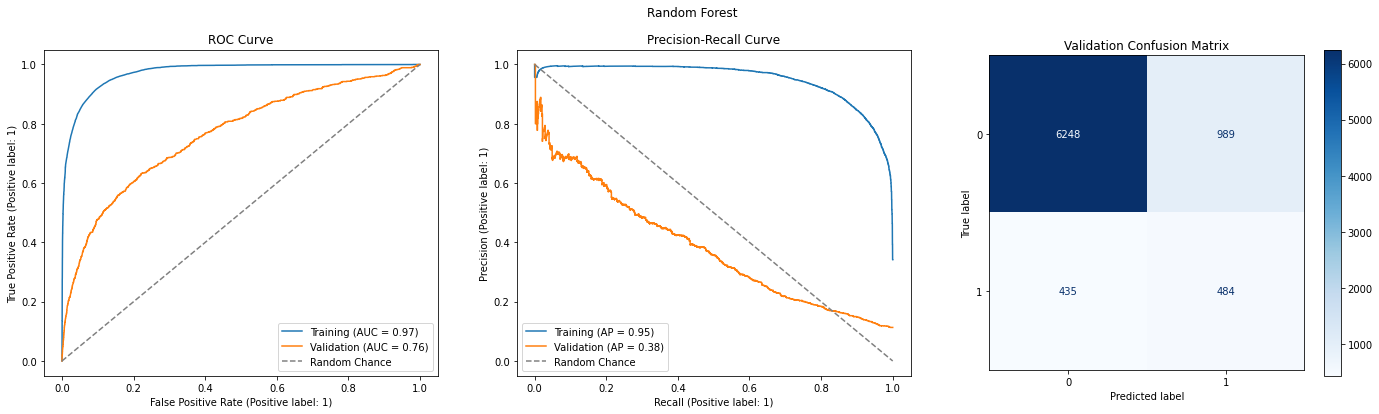

In [358]:
plot_classification_metric(random_forest_model, train_ds, val_ds, 'Random Forest')

> ## Ensemble Model
> but let's try to combine the models we have trained to see how the performance of the ensemble model will be. i will pick the best model from our arsenal of models and use it to predict the test set.

In [359]:
ensemble_model = StackingClassifier([
    ('rf', random_forest_model['model']),
    ('mlp', lr_model['model'])
],
    final_estimator=mlp_model['model'],
)

ensemble_model = create_model_pipeline(ensemble_model)
ensemble_model.fit(x_train, y_train);

> okay after the training was done we can then plot the same metric we use before and compare them to see how the performance of the ensemble model is.
> from this stage there is no much change in the performance of the ensemble model but it have .01 AUC improvement over previous model. so i will use this model in the final submission.

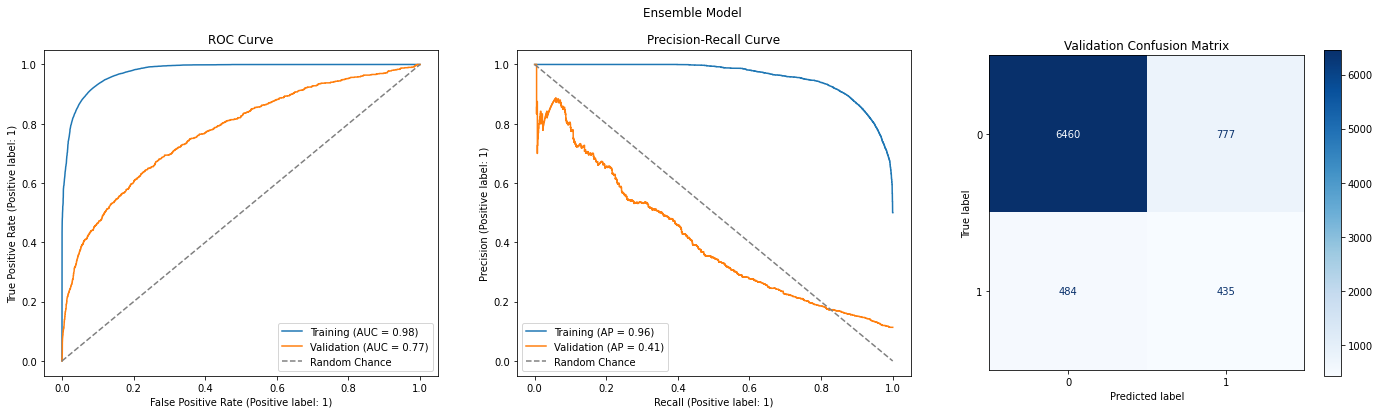

In [360]:
plot_classification_metric(ensemble_model, train_ds, val_ds, 'Ensemble Model')

# IX. Model Inference
> after we gone picking the most capable model using k-fold cross validation then Hypertune the model using grid search. and ensemble the model to increase the performance further we can start to test the model on the test set.

In [361]:
_y = ensemble_model.predict(x_test)

result = pd.DataFrame(np.array([y_test, _y]).T, columns=['Actual', 'Predicted'])
result['Correct'] = result['Actual'] == result['Predicted']

result

,Actual,Predicted,Correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
407,0,0,True
408,0,0,True
409,0,0,True
410,1,1,True


> from the calculation below we can see that model achieved a 84% accuracy on the test set but have low score on precision and recall.

In [362]:
print(f"Accuracy".ljust(12), f": {result['Correct'].mean() * 100:.2f}%")
print(f"Precision".ljust(12), f": {metrics.precision_score(y_test, _y):.2f}")
print(f"Recall".ljust(12), f": {metrics.recall_score(y_test, _y):.2f}")

Accuracy     : 83.98%
Precision    : 0.36
Recall       : 0.54


# X. Analysis
> to be able to understand the model i will plot the input sensitivity and input specification to see how the model respond to the input change.
> this method allow us to pin point what feature is important to the model and what is not.

> here i define our baseline input i chosee the common feature of our dataset when age is 22.

In [363]:
common = df[df['target'] == 1].groupby('age').agg(lambda x: stats.mode(x)[0][0]).reset_index()
common = common[common['age'] == 22]
common = common.to_dict('records')[0]

pd.DataFrame(common, index=['age']).T

,age
age,22
job,student
marital,single
education,high.school
default,no
housing,yes
loan,no
contact,cellular
month,may
day_of_week,fri


In [364]:
def get_space(df, sample, col, n=100):
    if df[col].dtype == 'object':
        _space = np.unique(df[col])
    else:
        _original_space = df[col].max() - df[col].min() + 1
        _space = np.linspace(df[col].min(), df[col].max(), int(_original_space) if _original_space < n else n)

    latent_input = []
    for value in _space:
        _sample = sample.copy()
        _sample[col] = value
        latent_input.append(_sample)

    return _space, pd.DataFrame(latent_input)

In [365]:
def plot_latent_sweep(df, a, b, model, ax=plt):
    ax.set_title(f'{model[-1].__class__.__name__}')

    for row in get_space(df, common, a)[1].to_dict(orient="records"):
        _space, latent = get_space(df, row, b)

        cat = row[a]

        gt = df[(df[a] == cat)]
        ax.scatter(gt[b], gt['target'], alpha=.33)

        _y = model.predict_proba(latent)[:, 1]
        ax.plot(_space, _y, label=cat)

    ax.axhline(.5, color='k', linestyle='--', label='Probability Threshold (.5)')
    ax.set_ylabel("Probability")
    ax.set_xlabel(b)
    ax.legend()

In [366]:
def plot_input_sensitivity(a, b):
    _, ax = plt.subplots(2, 2, figsize=(8 * 3, 6 * 2))

    plot_latent_sweep(df, a, b, model=lr_model, ax=ax[0, 0])
    plot_latent_sweep(df, a, b, model=random_forest_model, ax=ax[0, 1])

    plot_latent_sweep(df, a, b, model=mlp_model, ax=ax[1, 0])
    plot_latent_sweep(df, a, b, model=ensemble_model, ax=ax[1, 1])

> let's start from the month and euribor3m. as we can see from the graph below that most of the model decide that change of euribor3m is not important to the model output we can conclude this by seeing the line of most model not changing at all when we sweep the euribor3m. and fromthe graph show that eubor3m and the month is not so importand to the output

> the line in graph represent the categorical feature that we choose in this case is month. and the poin in each side represent the ground truth distribution of output

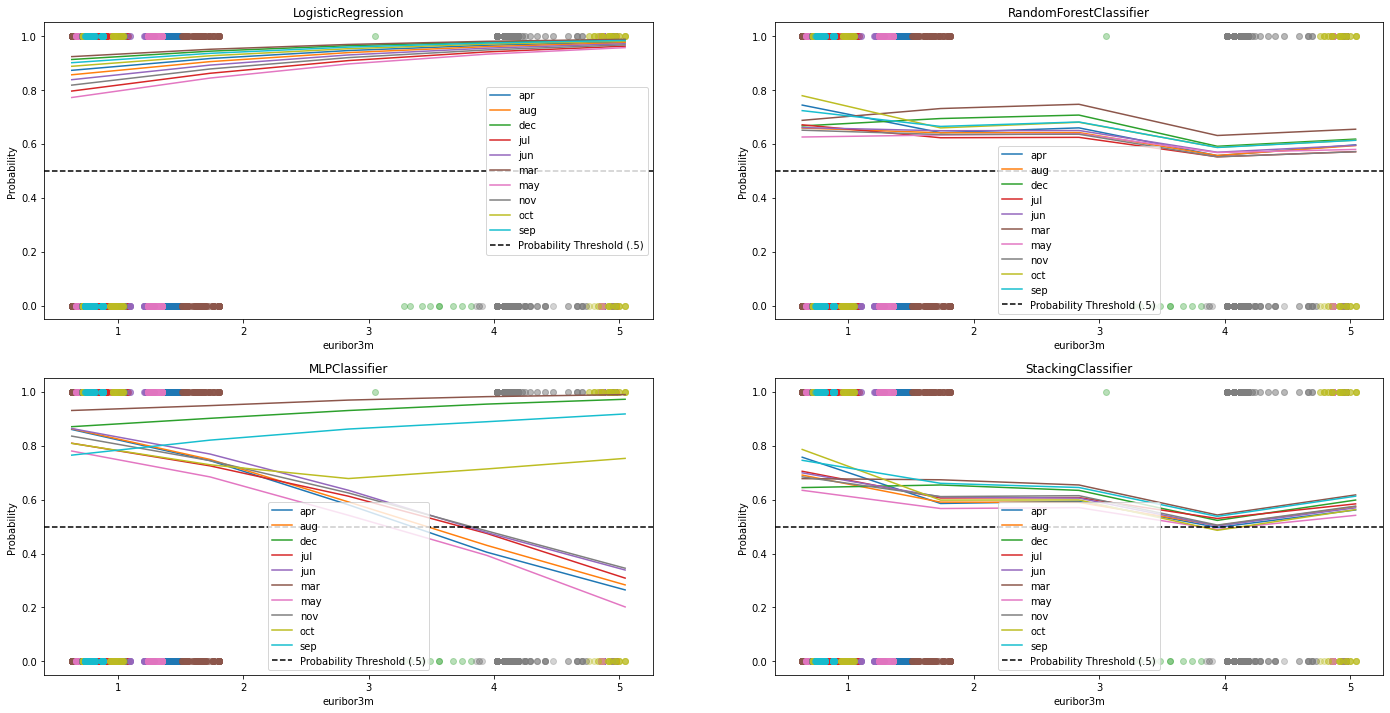

In [367]:
plot_input_sensitivity('month', 'euribor3m')

> insight above also true for the feature bellow because the most of model still not showing any change in the output when we sweep the pdays. or poutcome

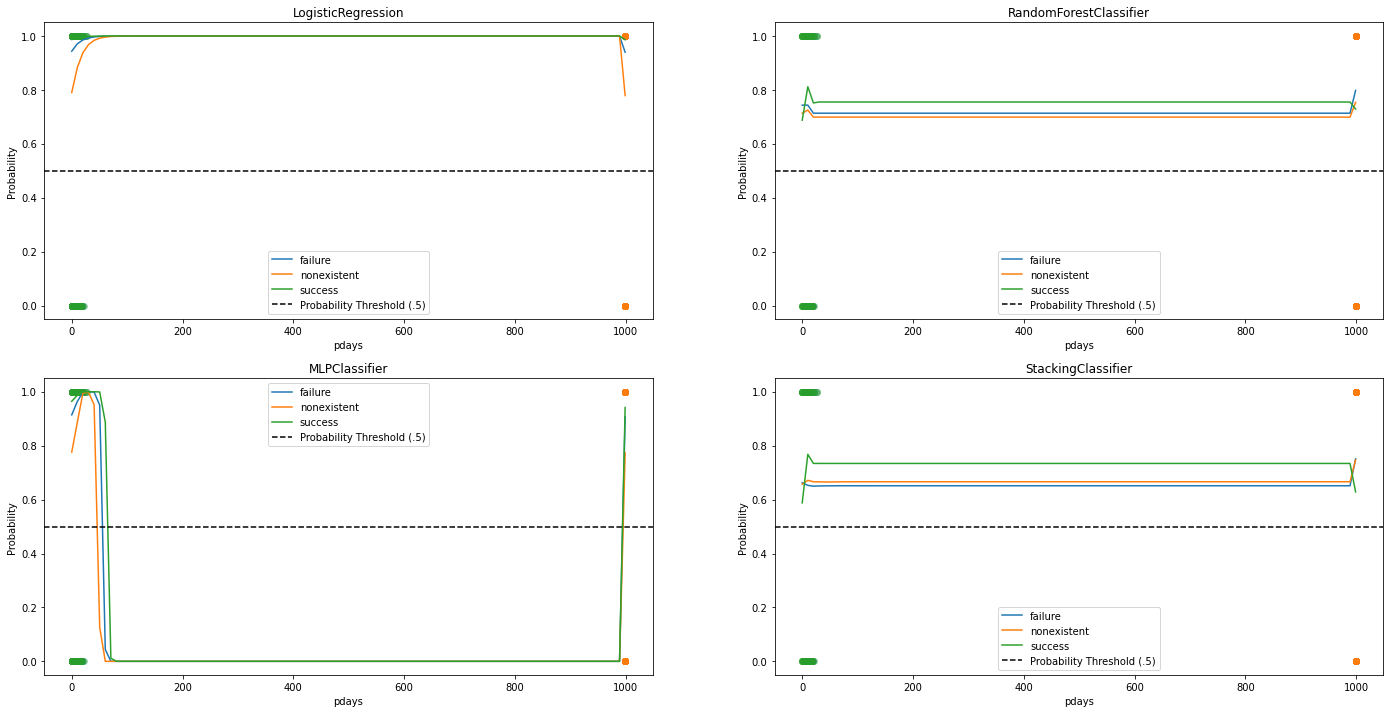

In [368]:
plot_input_sensitivity('poutcome', 'pdays')

> this one is interesting because most of our model agree to predict positive when nr_employed is less than 5000 ish and change the output to negative when nr_employed is greater than 5000. this one is deciding feature for our output. and classified as important feature.

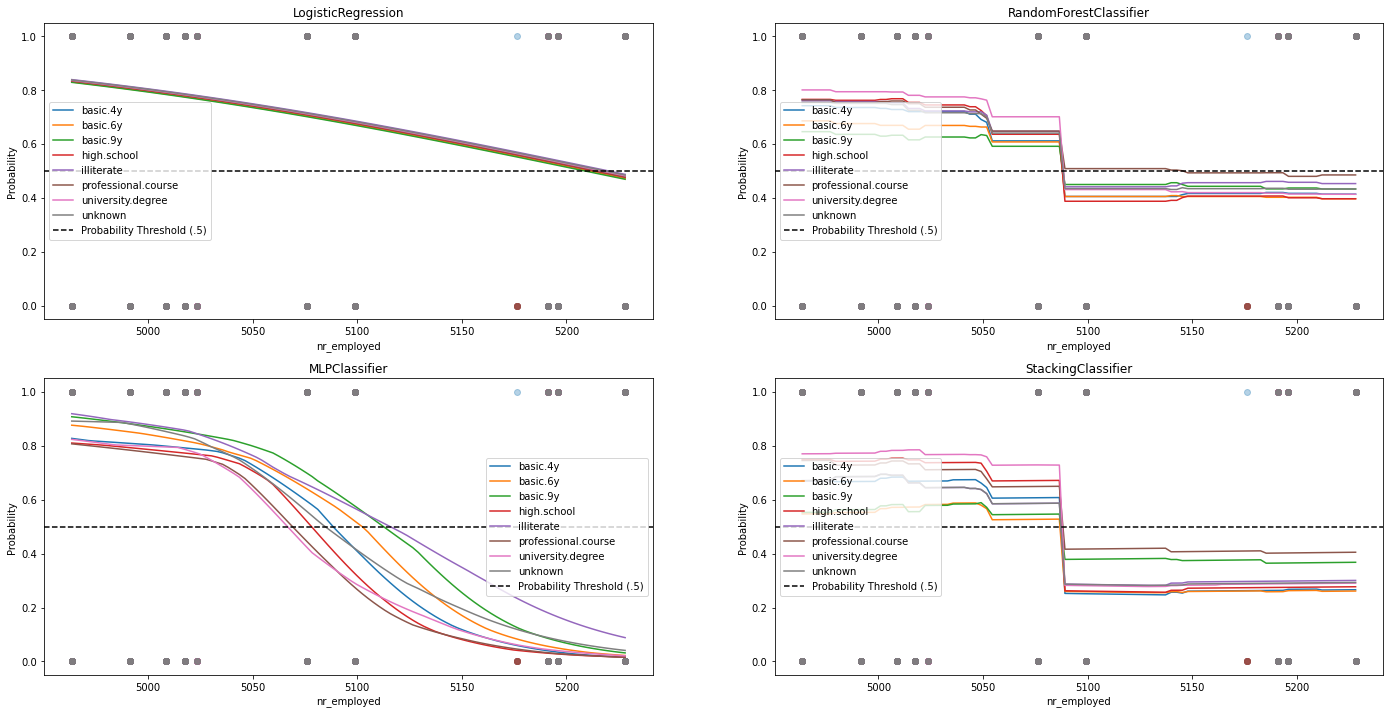

In [369]:
plot_input_sensitivity('education', 'nr_employed')

> After all that we have done before we can conclude many interesting thing that we found in the journey.
- the input feature is considered as not correlated directly with the output feature.
- some feature is not important to the model output.
- many outlier in our dataset is not because os mistreatment of the data but because the rule when generating the dataset like pdays that define when no call was perform previously it was set 999 with in this case was not benefiting our model
- many outlier was normalized by PowerTransformer and does not need to trim or clip the data that can cause the change of distribution of the data.
- it is important to separate and treat outlier with the training set only to prevent data leakage.
- it is important to pick the correct model for correct problem like in this case the best performing model was an ensemble model. and the more advance model was unable to perform well in this case MLP because the model was unable to outrank the ensemble model.
- by combining the model we can improve the performance of the model and take the best of each model.
- with sweeping the input of our model we can see more clearly what input is important to the model output. and we can start to improving the model more by more selectively selecting the input feature.

> let try to implement our model in the business scenario.
> let's say my company want my help to short-list the best candidates for a new campaign to better increase the ration of sales / call.
> lets use our model that we train before to achieve this goal.

In [400]:
_y = ensemble_model.predict_proba(x_val)[:, 1]

> let trade our precision to better gain recall. in this case i want to gain 80% of the recall. so we will only miss 20% of positive customer that doest not included into shortlist.

In [406]:
recall = 0
threshold = .5

while recall < .8:
    threshold -= .01
    recall = metrics.recall_score(y_val, _y > threshold)

print(f'Threshold: {threshold:.2f}')
print(f'Precision: {metrics.precision_score(y_val, _y > threshold):.2f}')
print(f'Recall: {recall:.2f}')

Threshold: 0.08
Precision: 0.18
Recall: 0.81


from the sweep we can see that we should use the .08 threshold to get 80% recall. so be it then

In [407]:
customer_list = x_test.copy()
customer_list['target'] = y_test

In [411]:
_y = ensemble_model.predict_proba(x_test)[:, 1]

> let's see what our test data consist of and on what percentage of the positive customer we can predict.

In [421]:
n_pos = customer_list[customer_list['target'] == 1].shape[0]
n_neg = customer_list[customer_list['target'] == 0].shape[0]
n_total = customer_list.shape[0]

print(f'Number of positive label: {n_pos}')
print(f'Number of negative label: {n_neg}')
print(f'Change : {(n_pos / n_total) * 100:.0f}%')

Number of positive label: 46
Number of negative label: 366
Change : 11%


> by using out best model and correct threshold we increasing the change of getting positive customer by 5%. if we have let's say 1 Million customer 5% is a significant change to save resources and time

In [420]:
n_pos = customer_list[_y > threshold][customer_list['target'] == 1].shape[0]
n_neg = customer_list[_y > threshold][customer_list['target'] == 0].shape[0]
n_total = customer_list[_y > threshold].shape[0]

print(f'Number of positive label in shortlist: {n_pos}')
print(f'Number of negative label in shortlist: {n_neg}')
print(f'Change : {(n_pos / n_total) * 100:.0f}%')

Number of positive label in shortlist: 36
Number of negative label in shortlist: 190
Change : 16%


> so in this trial he have successfully increased the ration of sales / call by 5%. and make our bos Happy